In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [2]:
# /media/juneyonglee/My Book/data/Chl-a/test/0/UST21_L3_Merged-Chla-1D_20210102_r5632_c2304.tiff
# /media/juneyonglee/My Book/Preprocessed/UST/Chl-a_8day/train/90/2012_01_20_sae.tiff
# img = input()
# img = cv2.imread(img,cv2.IMREAD_UNCHANGED)
# plt.imshow(img)
# plt.axis(False)
# plt.colorbar()


In [3]:
# np.sum(np.isnan(img))/(256**2)*100

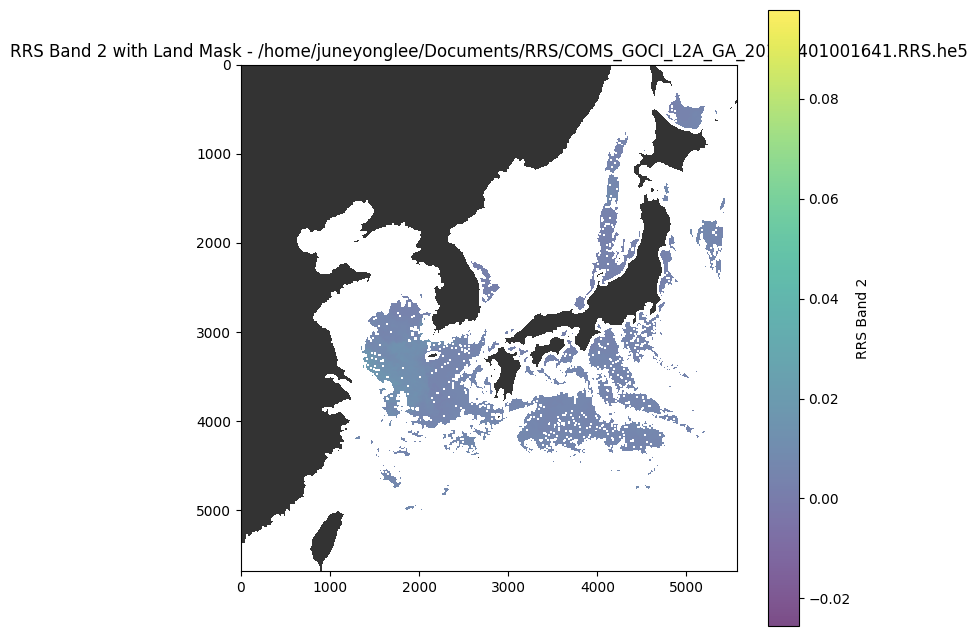

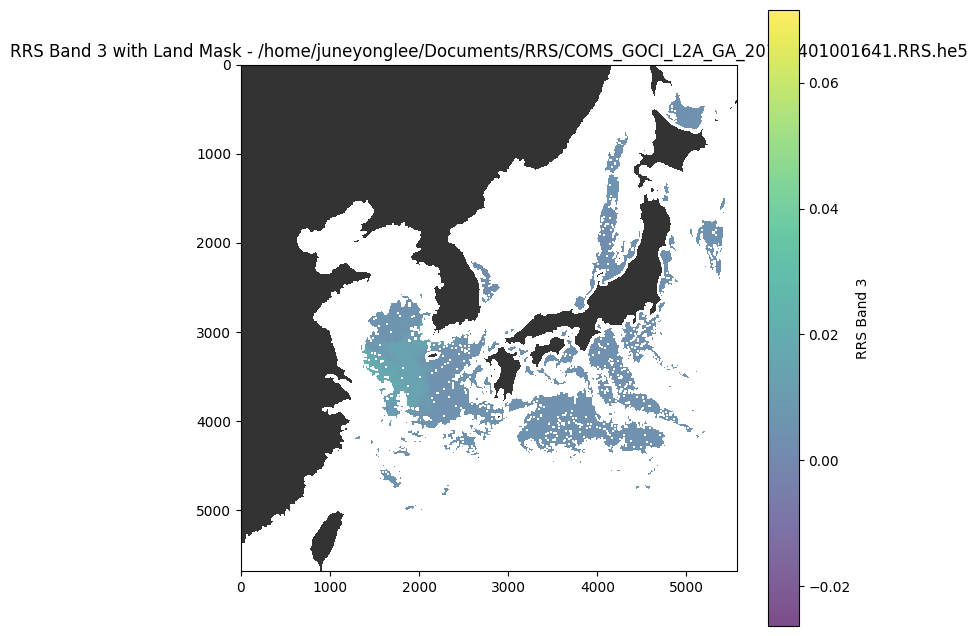

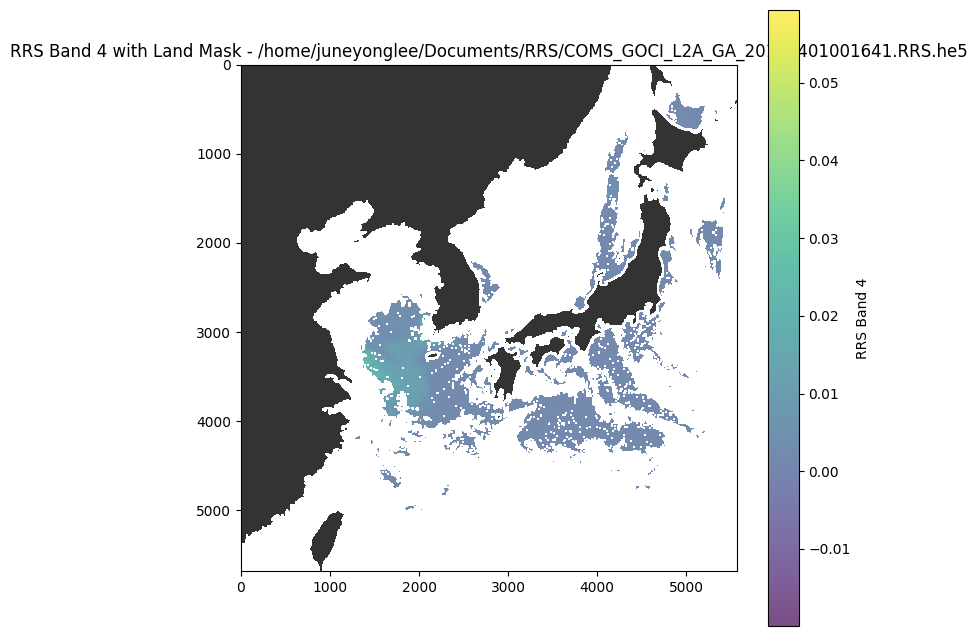

In [83]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# RRS 파일 경로 및 육지/바다 npy 파일 경로
file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401001641.RRS.he5'
land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI.npy'

# 사용할 밴드 리스트 (2, 3, 4번 밴드 예시)
band_lst = [2, 3, 4]

# 특정 범위의 좌표 설정 (필요에 따라 지정할 수 있습니다. 여기서는 전체 범위를 사용)
# 범위를 설정하지 않으면 데이터 전체를 사용합니다.
y_min, y_max = 0, None
x_min, x_max = 0, None

def display_rrs_with_land_mask(file_path, land_mask_path, band_lst, y_min=None, y_max=None, x_min=None, x_max=None):
    # 육지/바다 마스크 불러오기
    land_mask = np.load(land_mask_path)

    # netCDF 파일 열기
    try:
        f = nc.Dataset(file_path, 'r')
    except:
        print(f"Failed to open file: {file_path}")
        return

    # 각 밴드에 대해 데이터 읽고 시각화
    for band in band_lst:
        try:
            # netCDF 형식으로 데이터를 읽음
            rrs_data = f['HDFEOS']['GRIDS']['Image Data']['Data Fields']['Band ' + str(band) + ' RRS Image Pixel Values']
        except KeyError:
            print(f"Band {band} not found in file {file_path}")
            continue

        # numpy 배열로 변환
        np_rrs = np.array(rrs_data)

        # 지정된 좌표 범위 내 데이터만 선택
        np_rrs = np_rrs[y_min:y_max, x_min:x_max]

        # 육지 마스크도 동일한 범위로 자르기
        land_mask_cropped = land_mask[y_min:y_max, x_min:x_max]

        # 결측치를 처리 (보통 -999.0 값을 결측치로 가정)
        np_rrs = np.where(np_rrs == -999.0, np.nan, np_rrs)

        # 이미지 출력
        plt.figure(figsize=(8, 8))
        
        # RRS 데이터 이미지
        plt.imshow(np_rrs, cmap='viridis', alpha=0.7)
        plt.colorbar(label=f'RRS Band {band}')
        
        # 육지 마스크를 빨간색으로 강조 (land_mask가 1이면 육지, 0이면 바다라고 가정)
        plt.imshow(np.ma.masked_where(land_mask_cropped == 0, land_mask_cropped), cmap=ListedColormap(['black', 'white']), alpha=0.8)

        plt.title(f'RRS Band {band} with Land Mask - {file_path}')
        plt.show()

    # 파일 닫기
    f.close()

# 밴드별로 RRS 데이터와 육지 마스크 함께 시각화
display_rrs_with_land_mask(file_path, land_mask_path, band_lst, y_min, y_max, x_min, x_max)


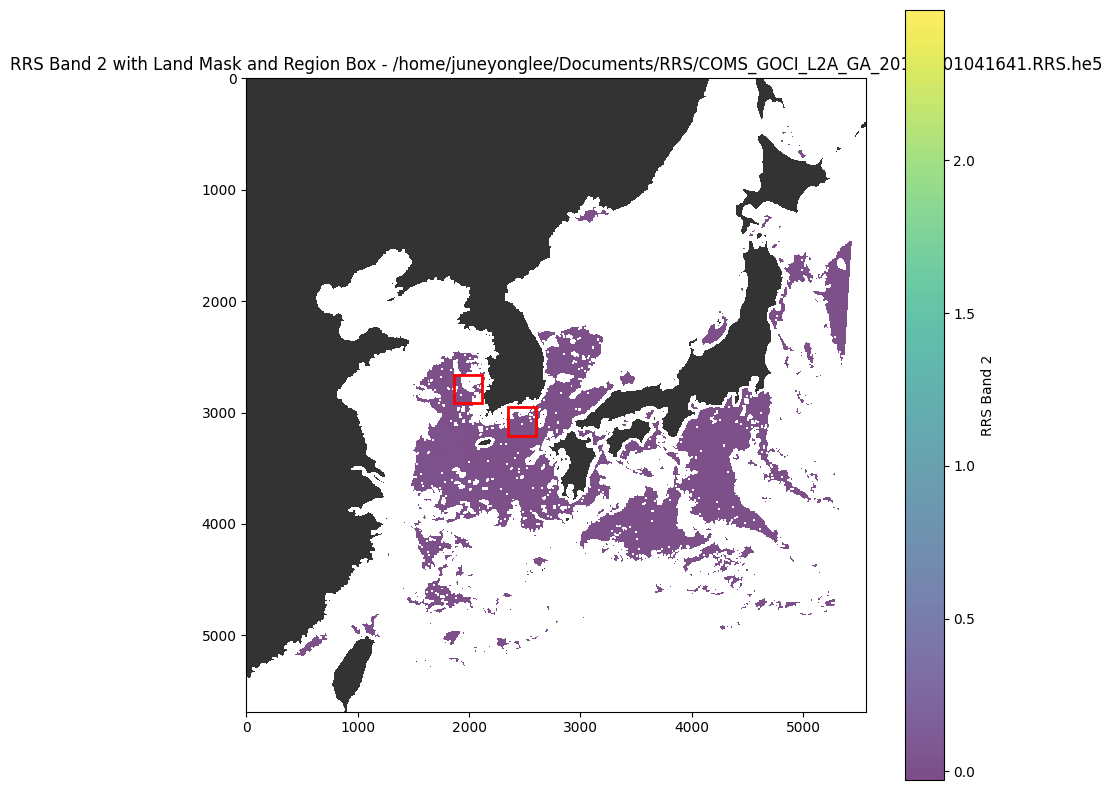

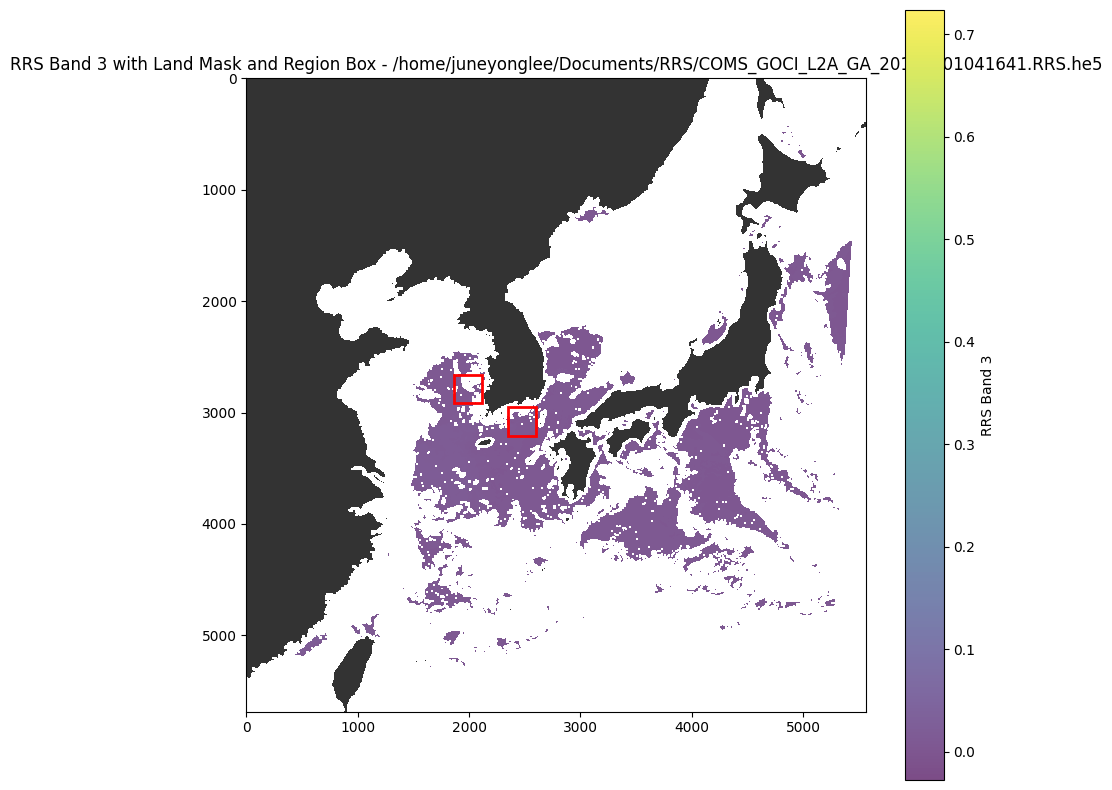

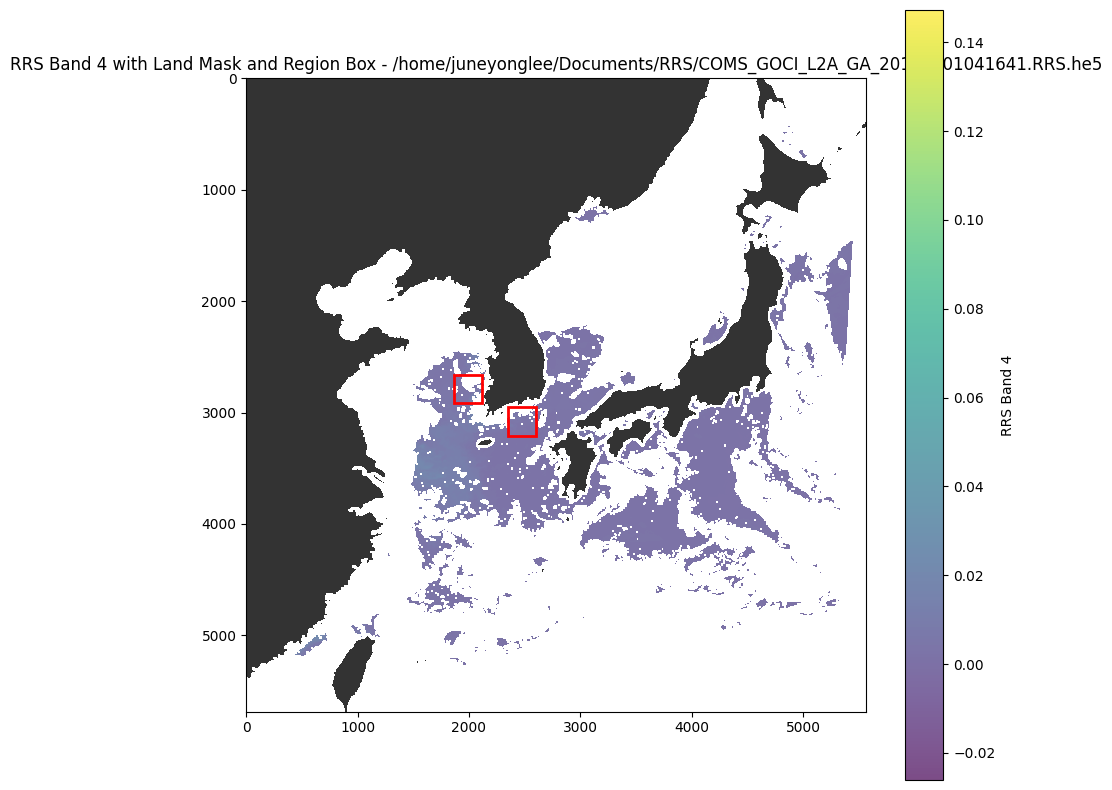

In [116]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

# RRS 파일 경로 및 육지/바다 npy 파일 경로
# file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401001641.RRS.he5'
file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401041641.RRS.he5'

land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI.npy'

# 사용할 밴드 리스트 (2, 3, 4번 밴드 예시)
band_lst = [2, 3, 4]

# # 기존 낙동강 좌표 설정 (픽셀 좌표)
# region1_x_min, region1_x_max = 2346, 2602
# region1_y_min, region1_y_max = 3053, 3309

# # 기존 새만금 좌표 설정 (픽셀 좌표)
# region2_x_min, region2_x_max = 1761, 2017
# region2_y_min, region2_y_max = 2309, 2565

# # 자유롭게 낙동강 좌표 설정 (픽셀 좌표)
# region1_x_min, region1_x_max = 2446, 2702
# region1_y_min, region1_y_max = 2953, 3209

# # 자유롭게 새만금 좌표 설정 (픽셀 좌표)
# region2_x_min, region2_x_max = 1861, 2117
# region2_y_min, region2_y_max = 2659, 2915

# 동쪽해, 새만금 및 낙동강 좌표 범위 설정 (픽셀 좌표로 변환된 값)
# # 동쪽해 
# region_x_min, region_x_max = 2702, 2958
# region_y_min, region_y_max = 2397, 2653
# 낙동강 
region1_x_min, region1_x_max = 2346, 2602
region1_y_min, region1_y_max = 2953, 3209
# 새만금 
region2_x_min, region2_x_max = 1861, 2117
region2_y_min, region2_y_max = 2659, 2915


def display_rrs_with_land_mask_and_box(file_path, land_mask_path, band_lst, region_x_min, region_x_max, region_y_min, region_y_max):
    # 육지/바다 마스크 불러오기
    land_mask = np.load(land_mask_path)

    # netCDF 파일 열기
    try:
        f = nc.Dataset(file_path, 'r')
    except:
        print(f"Failed to open file: {file_path}")
        return

    # 각 밴드에 대해 데이터 읽고 시각화
    for band in band_lst:
        try:
            # netCDF 형식으로 데이터를 읽음
            rrs_data = f['HDFEOS']['GRIDS']['Image Data']['Data Fields']['Band ' + str(band) + ' RRS Image Pixel Values']
        except KeyError:
            print(f"Band {band} not found in file {file_path}")
            continue

        # numpy 배열로 변환
        np_rrs = np.array(rrs_data)

        # 육지 마스크 크기 맞추기 (전체 범위로)
        land_mask_cropped = land_mask[:np_rrs.shape[0], :np_rrs.shape[1]]

        # 결측치를 처리 (보통 -999.0 값을 결측치로 가정)
        np_rrs = np.where(np_rrs == -999.0, np.nan, np_rrs)

        # 이미지 출력
        plt.figure(figsize=(10, 10))
        
        # RRS 데이터 이미지
        plt.imshow(np_rrs, cmap='viridis', alpha=0.7)
        plt.colorbar(label=f'RRS Band {band}')
        
        # 육지 마스크를 빨간색으로 강조 (land_mask가 1이면 육지, 0이면 바다라고 가정)
        plt.imshow(np.ma.masked_where(land_mask_cropped == 0, land_mask_cropped), cmap=ListedColormap(['black', 'white']), alpha=0.8)

        # # 동쪽해 
        # rect = Rectangle((region_x_min, region_y_min), region_x_max - region_x_min, region_y_max - region_y_min,
        #                  linewidth=2, edgecolor='r', facecolor='none')
        # plt.gca().add_patch(rect)

        # 새만금 및 낙동강 좌표 범위에 빨간색 사각형 추가
        rect1 = Rectangle((region1_x_min, region1_y_min), region1_x_max - region1_x_min, region1_y_max - region1_y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect1)

        # 새만금 및 낙동강 좌표 범위에 빨간색 사각형 추가
        rect2 = Rectangle((region2_x_min, region2_y_min), region2_x_max - region2_x_min, region2_y_max - region2_y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect2)

        plt.title(f'RRS Band {band} with Land Mask and Region Box - {file_path}')
        plt.show()

    # 파일 닫기
    f.close()

# 밴드별로 RRS 데이터와 육지 마스크, 새만금 및 낙동강 좌표 범위에 네모 박스 표시
display_rrs_with_land_mask_and_box(file_path, land_mask_path, band_lst, region_x_min, region_x_max, region_y_min, region_y_max)


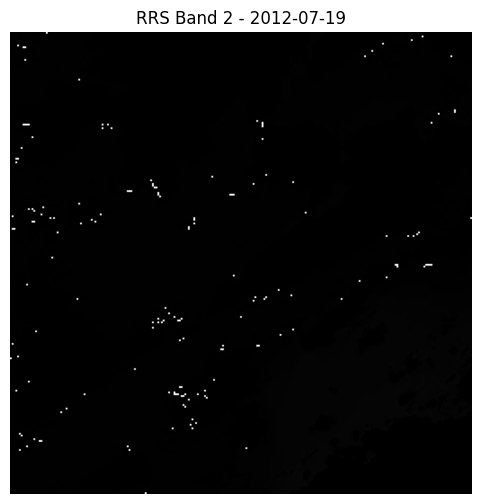

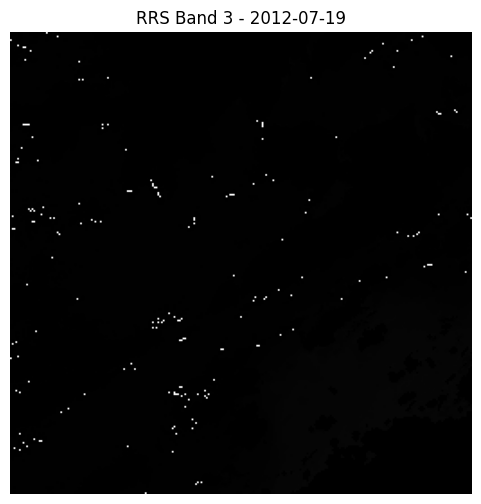

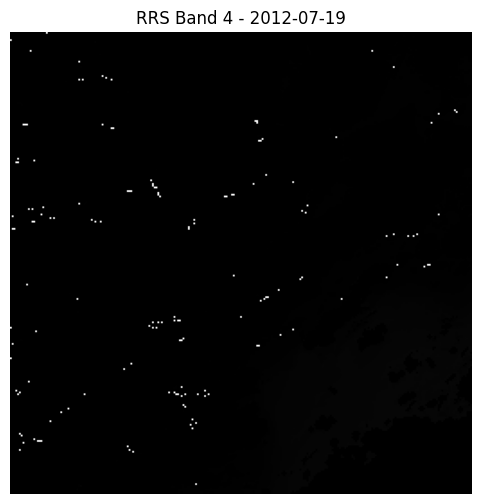

In [112]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# 기존 낙동강 좌표 설정 (픽셀 좌표)
x_min = 2346
x_max = 2602
y_min = 3053
y_max = 3309
# 기존 새만금 좌표 설정 (픽셀 좌표)
x_min = 1761
x_max = 2017
y_min = 2309
y_max = 2565
# 낙동강 좌표 설정 (픽셀 좌표)
region1_x_min, region1_x_max = 2446, 2702
region1_y_min, region1_y_max = 2953, 3209

# 새만금 좌표 설정 (픽셀 좌표)
region2_x_min, region2_x_max = 1861, 2117
region2_y_min, region2_y_max = 2659, 2915


# 저장된 TIFF 파일 경로 설정
save_path = '/media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs'
# save_path = '/home/juneyonglee/Documents/RRS_preprocessed'
year = '2012'
month = '07'
day = '19'

# 밴드 리스트 설정
band_lst = [2, 3, 4]

# TIFF 파일을 밴드별로 읽어서 출력하는 함수
def display_rrs_band_images(save_path, year, month, day, band_lst):
    # 밴드별로 파일 읽고 출력
    for band in band_lst:
        file_path = os.path.join(save_path, year, month, day, f"RRS_band_{band}_sae_r{region2_x_min}_c{region2_y_min}.tiff")

        if os.path.exists(file_path):
            # TIFF 이미지 읽기
            rrs_img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            if rrs_img is None:
                print(f"Failed to load image for Band {band}: {file_path}")
                continue

            # 이미지의 데이터 타입 확인 및 변환
            if rrs_img.dtype != np.uint8:
                rrs_img = np.clip(rrs_img, 0, 255)  # 값이 범위를 넘는 경우 0~255로 클리핑
                rrs_img = rrs_img.astype(np.uint8)  # 8비트 이미지로 변환

            # 이미지 출력
            plt.figure(figsize=(6, 6))
            plt.imshow(rrs_img, cmap='gray')
            plt.title(f'RRS Band {band} - {year}-{month}-{day}')
            plt.axis('off')  # 축 표시 제거
            plt.show()
        else:
            print(f"File not found for Band {band}: {file_path}")

# 이미지 출력
display_rrs_band_images(save_path, year, month, day, band_lst)


현재 폴더: /home/juneyonglee/Documents
Loaded 20120104_nak_r3990_c4732.tiff with shape (256, 256) and dtype uint16
20120104_nak_r3990_c4732.tiff 전체 NaN 값 비율: 0.00%
20120104_nak_r3990_c4732.tiff 0 값 비율: 8.14%
20120104_nak_r3990_c4732.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


/tmp/ipykernel_3735345/2584858522.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용


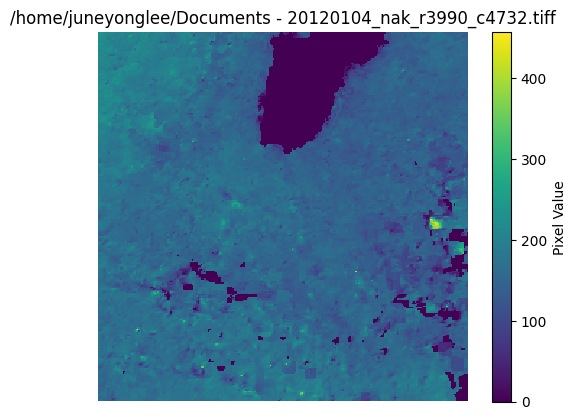

Loaded 20120104_nak_r4005_c4575.tiff with shape (256, 256) and dtype uint16
20120104_nak_r4005_c4575.tiff 전체 NaN 값 비율: 0.00%
20120104_nak_r4005_c4575.tiff 0 값 비율: 0.42%
20120104_nak_r4005_c4575.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


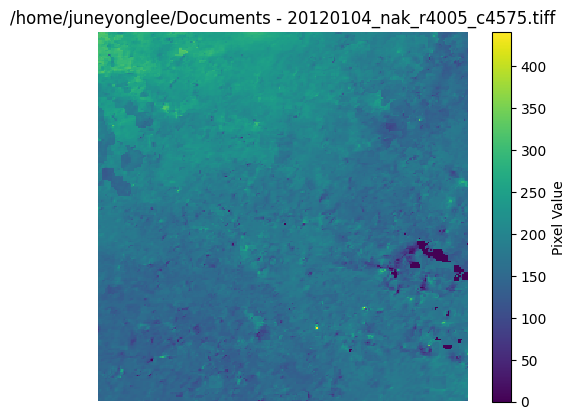

Loaded 20120104_nak_r3989_c4658.tiff with shape (256, 256) and dtype uint16
20120104_nak_r3989_c4658.tiff 전체 NaN 값 비율: 0.00%
20120104_nak_r3989_c4658.tiff 0 값 비율: 6.64%
20120104_nak_r3989_c4658.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


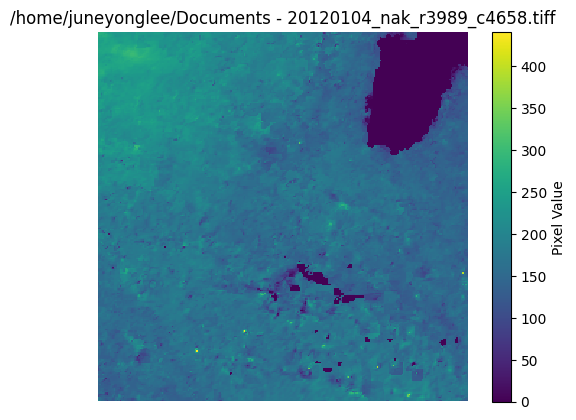

Loaded 20120105_nak_r3930_c4740.tiff with shape (256, 256) and dtype uint16
20120105_nak_r3930_c4740.tiff 전체 NaN 값 비율: 0.00%
20120105_nak_r3930_c4740.tiff 0 값 비율: 11.29%
20120105_nak_r3930_c4740.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


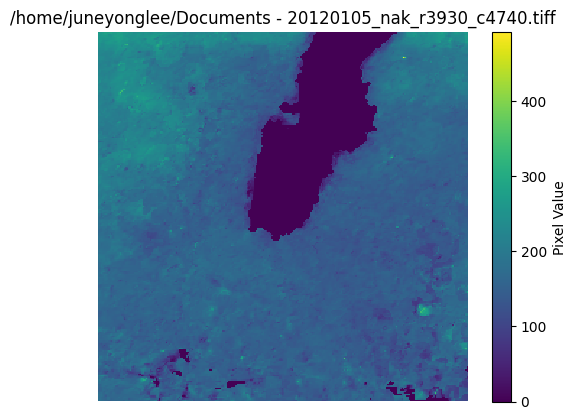

Loaded 20120105_nak_r3928_c4633.tiff with shape (256, 256) and dtype uint16
20120105_nak_r3928_c4633.tiff 전체 NaN 값 비율: 0.00%
20120105_nak_r3928_c4633.tiff 0 값 비율: 5.58%
20120105_nak_r3928_c4633.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


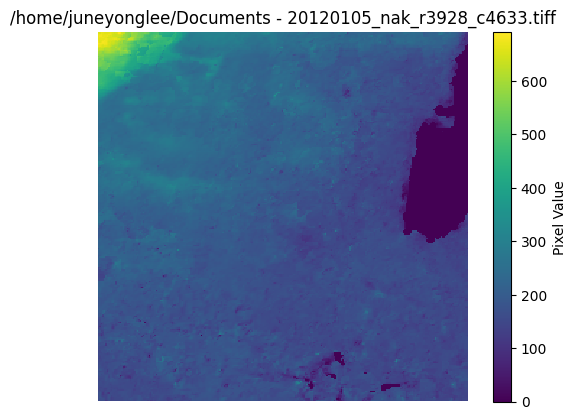

Loaded 20120104_nak_r4002_c4688.tiff with shape (256, 256) and dtype uint16
20120104_nak_r4002_c4688.tiff 전체 NaN 값 비율: 0.00%
20120104_nak_r4002_c4688.tiff 0 값 비율: 5.85%
20120104_nak_r4002_c4688.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


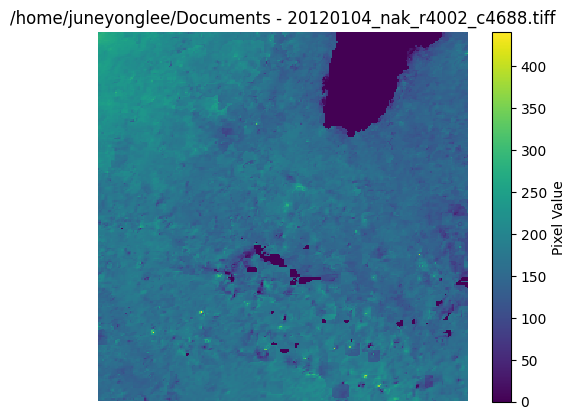

현재 폴더: /home/juneyonglee/Documents/RRS
현재 폴더: /home/juneyonglee/Documents/RRS_preprocessed
Loaded RRS_2_sae_2012y_08m_04d_r1861.tiff with shape (257, 257) and dtype uint8
RRS_2_sae_2012y_08m_04d_r1861.tiff 전체 NaN 값 비율: 0.00%
RRS_2_sae_2012y_08m_04d_r1861.tiff 0 값 비율: 6.74%
RRS_2_sae_2012y_08m_04d_r1861.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


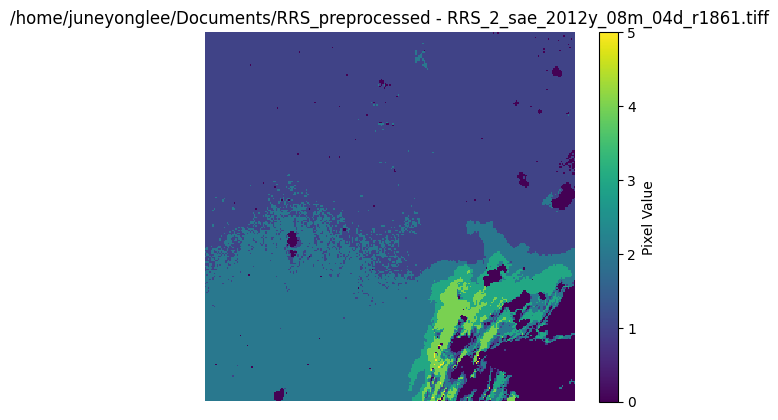

Loaded RRS_2_sae_2012y_08m_31d_r1861.tiff with shape (257, 257) and dtype uint8
RRS_2_sae_2012y_08m_31d_r1861.tiff 전체 NaN 값 비율: 0.00%
RRS_2_sae_2012y_08m_31d_r1861.tiff 0 값 비율: 7.93%
RRS_2_sae_2012y_08m_31d_r1861.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


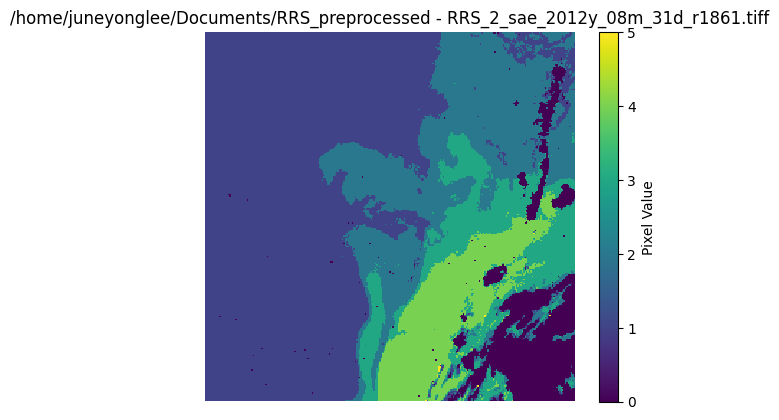

Loaded RRS_2_sae_2018y_08m_05d_r1861.tiff with shape (257, 257) and dtype uint8
RRS_2_sae_2018y_08m_05d_r1861.tiff 전체 NaN 값 비율: 0.00%
RRS_2_sae_2018y_08m_05d_r1861.tiff 0 값 비율: 8.01%
RRS_2_sae_2018y_08m_05d_r1861.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


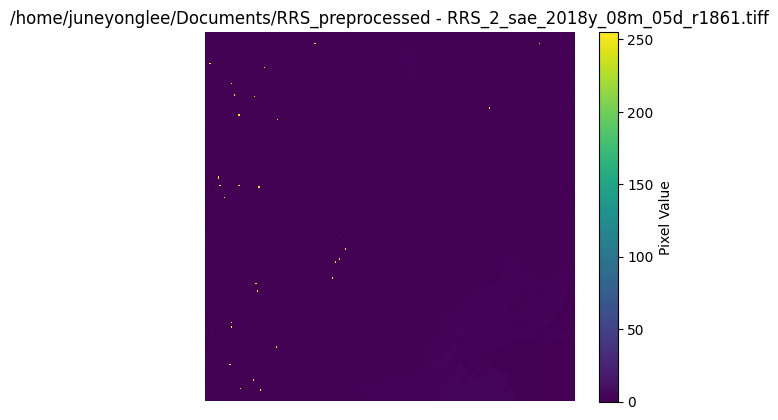

Loaded RRS_2_sae_2018y_08m_06d_r1861.tiff with shape (257, 257) and dtype uint8
RRS_2_sae_2018y_08m_06d_r1861.tiff 전체 NaN 값 비율: 0.00%
RRS_2_sae_2018y_08m_06d_r1861.tiff 0 값 비율: 7.76%
RRS_2_sae_2018y_08m_06d_r1861.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


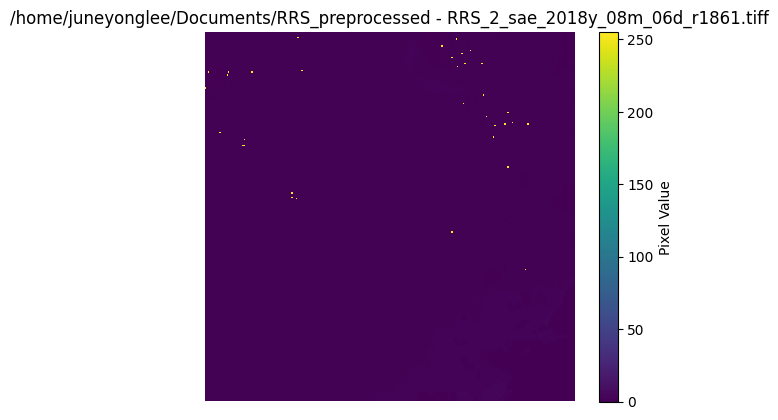

Loaded RRS_2_sae_2012y_08m_06d_r1861.tiff with shape (257, 257) and dtype uint8
RRS_2_sae_2012y_08m_06d_r1861.tiff 전체 NaN 값 비율: 0.00%
RRS_2_sae_2012y_08m_06d_r1861.tiff 0 값 비율: 5.71%
RRS_2_sae_2012y_08m_06d_r1861.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


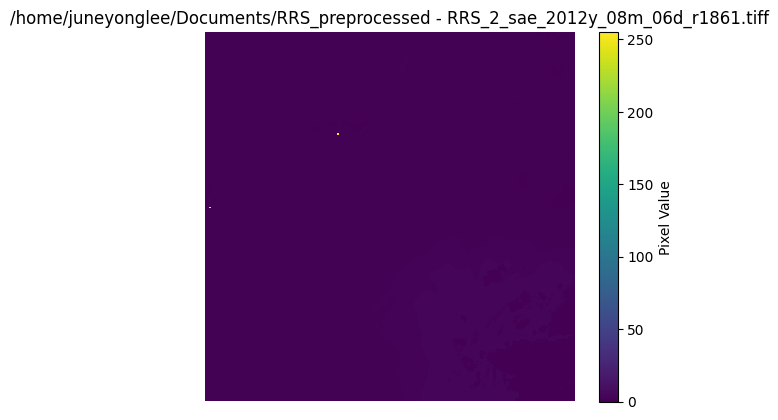

Loaded RRS_2_sae_2017y_05m_22d_r1861.tiff with shape (257, 257) and dtype uint8
RRS_2_sae_2017y_05m_22d_r1861.tiff 전체 NaN 값 비율: 0.00%
RRS_2_sae_2017y_05m_22d_r1861.tiff 0 값 비율: 9.20%
RRS_2_sae_2017y_05m_22d_r1861.tiff 육지를 제외한 해양 영역 NaN 비율: 0.00%


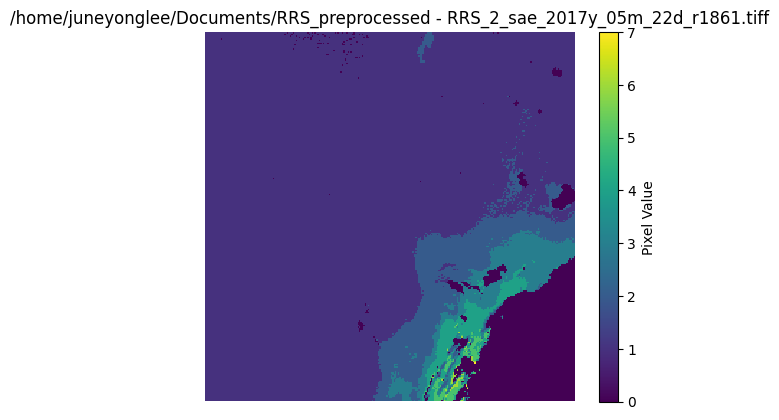

In [113]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff  # 수정

# 최상위 디렉토리 경로 설정
root_directory = "/home/juneyonglee/Documents"

# 사용자 정의 컬러맵 생성 (해양 데이터용)
def create_custom_cmap():
    viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용
    return viridis

# 사용자 정의 컬러맵 설정
custom_cmap = create_custom_cmap()

# 디렉토리 내의 모든 하위 폴더와 파일을 순차적으로 처리
image_count = 0  # 출력할 이미지 카운터
max_images = 20  # 출력할 최대 이미지 수

for dirpath, dirnames, filenames in os.walk(root_directory):
    print(f"현재 폴더: {dirpath}")  # 현재 폴더 경로 출력
    
    # 해당 폴더 내의 모든 tiff 파일을 처리
    for filename in filenames:
        if filename.endswith(".tiff"):  # TIFF 파일만 선택
            file_path = os.path.join(dirpath, filename)
            
            # tifffile을 사용하여 이미지 불러오기 (16비트 이미지로 읽기)
            img = tiff.imread(file_path)

            if img is None:
                print(f"{filename} could not be loaded.")
                continue
            
            print(f"Loaded {filename} with shape {img.shape} and dtype {img.dtype}")

            # 999 값을 NaN으로 변환 (육지 부분을 NaN으로 치환)
            img = np.where(img == 999, np.nan, img)

            # 전체 픽셀 수 계산
            total_pixels = img.shape[0] * img.shape[1]
            
            # NaN 값 비율 계산 (전체 영역에서 NaN 비율)
            nan_count = np.count_nonzero(np.isnan(img))
            nan_ratio = (nan_count / total_pixels) * 100

            # 0 값 비율 계산
            zero_count = np.count_nonzero(img == 0)
            zero_ratio = (zero_count / total_pixels) * 100

            # 육지(999)를 제외한 영역에서 결측치 비율 계산 (해양 영역만 대상)
            ocean_mask = ~np.isnan(img)  # NaN이 아닌 영역을 마스크로 만듦
            valid_ocean_pixels = np.sum(ocean_mask)  # 유효한 해양 픽셀 수
            ocean_nan_count = np.sum(np.isnan(img) & ocean_mask)  # 육지를 제외한 NaN 수
            ocean_nan_ratio = (ocean_nan_count / valid_ocean_pixels) * 100 if valid_ocean_pixels > 0 else 0
            
            # 출력
            print(f"{filename} 전체 NaN 값 비율: {nan_ratio:.2f}%")
            print(f"{filename} 0 값 비율: {zero_ratio:.2f}%")
            print(f"{filename} 육지를 제외한 해양 영역 NaN 비율: {ocean_nan_ratio:.2f}%")
            
            # 해양 데이터 시각화 (육지 부분은 NaN으로 표시)
            plt.imshow(img, cmap=custom_cmap, interpolation='none')
            plt.axis('off')  # 축 제거
            plt.colorbar(label='Pixel Value')  # 컬러맵 바 추가
            plt.title(f"{dirpath} - {filename}")  # 폴더 경로와 파일명 출력

            plt.show()  # 각 이미지별로 별도 창으로 보여줌

            image_count += 1  # 이미지 카운터 증가
            if image_count >= max_images:  # 최대 이미지 수에 도달하면 종료
                break
    if image_count >= max_images:  # 상위 루프에서도 종료
        break


/tmp/ipykernel_3735345/3904898512.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)  # viridis 컬러맵에서 256개의 색상 사용


마스크 로드 완료, 모양: (256, 256), 고유 값: [0 1]
현재 폴더: /home/juneyonglee/Documents
파일명: 20120104_nak_r3990_c4732.tiff
총 픽셀 수: 65536
TIFF 이미지에서 0 값 픽셀 수: 5335
0 값 픽셀 비율: 8.14%
최종 마스크된 이미지에서 NaN 비율: 2.12%


/tmp/ipykernel_3735345/3904898512.py:139: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3735345/3904898512.py:139: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3735345/3904898512.py:139: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3735345/3904898512.py:139: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3735345/3904898512.py:139: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3735345/3904898512.py:139: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3735345/3904898512.py:139: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s)

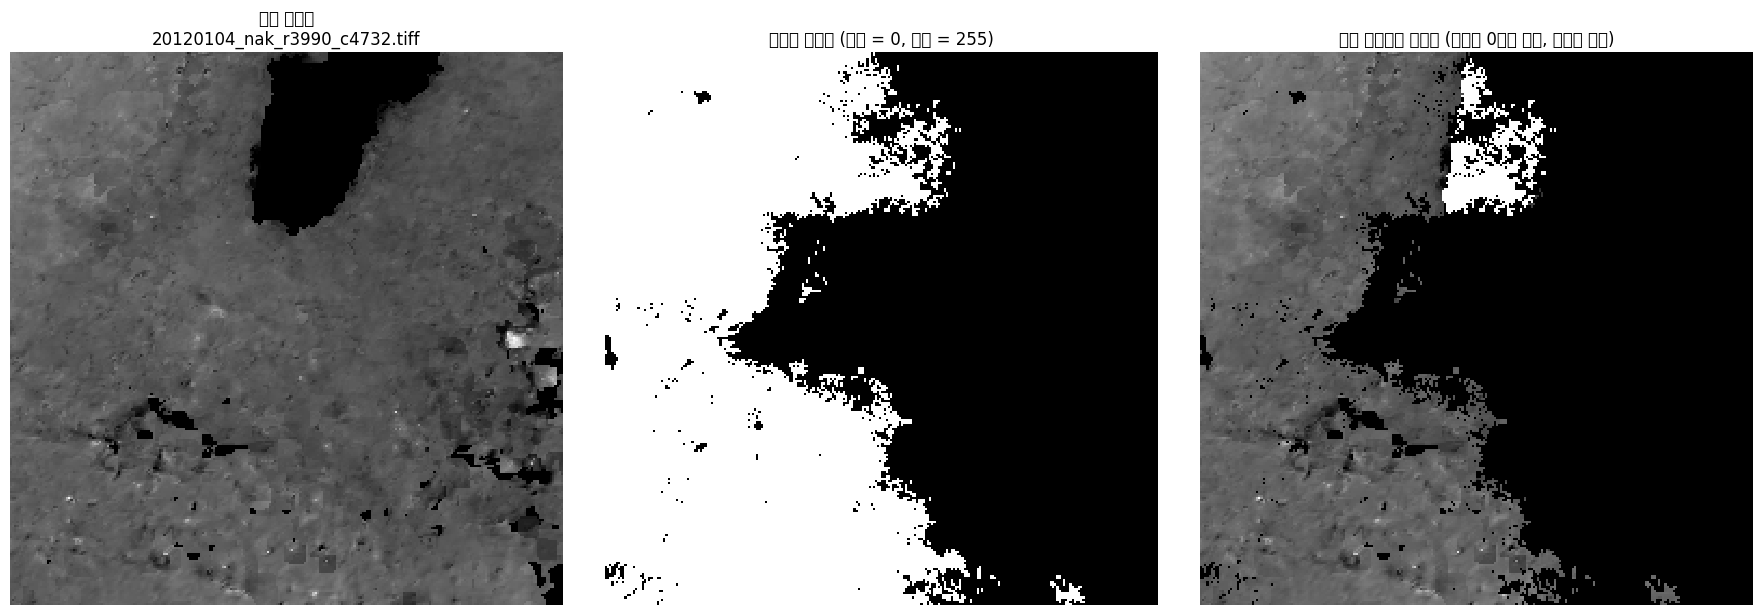

파일명: 20120104_nak_r4005_c4575.tiff
총 픽셀 수: 65536
TIFF 이미지에서 0 값 픽셀 수: 274
0 값 픽셀 비율: 0.42%
최종 마스크된 이미지에서 NaN 비율: 0.00%


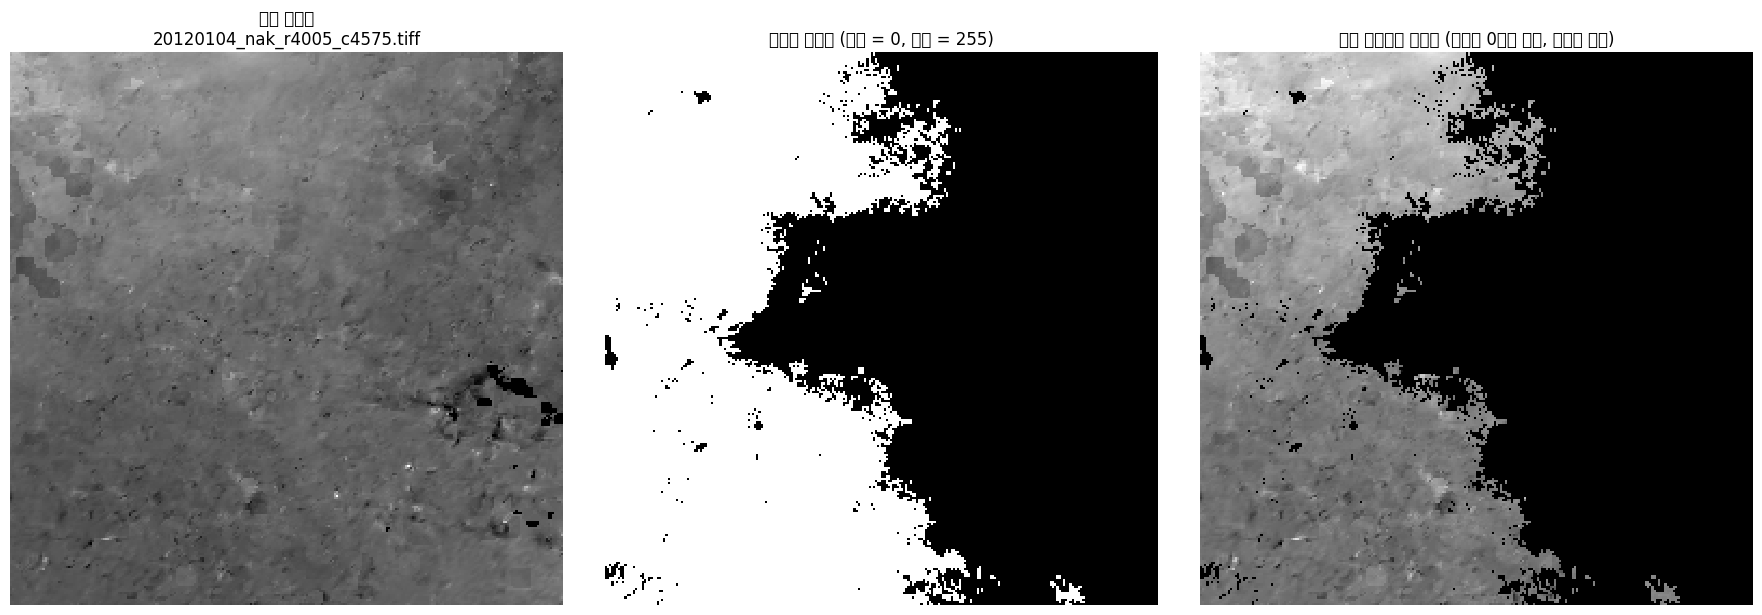

파일명: 20120104_nak_r3989_c4658.tiff
총 픽셀 수: 65536
TIFF 이미지에서 0 값 픽셀 수: 4349
0 값 픽셀 비율: 6.64%
최종 마스크된 이미지에서 NaN 비율: 0.00%


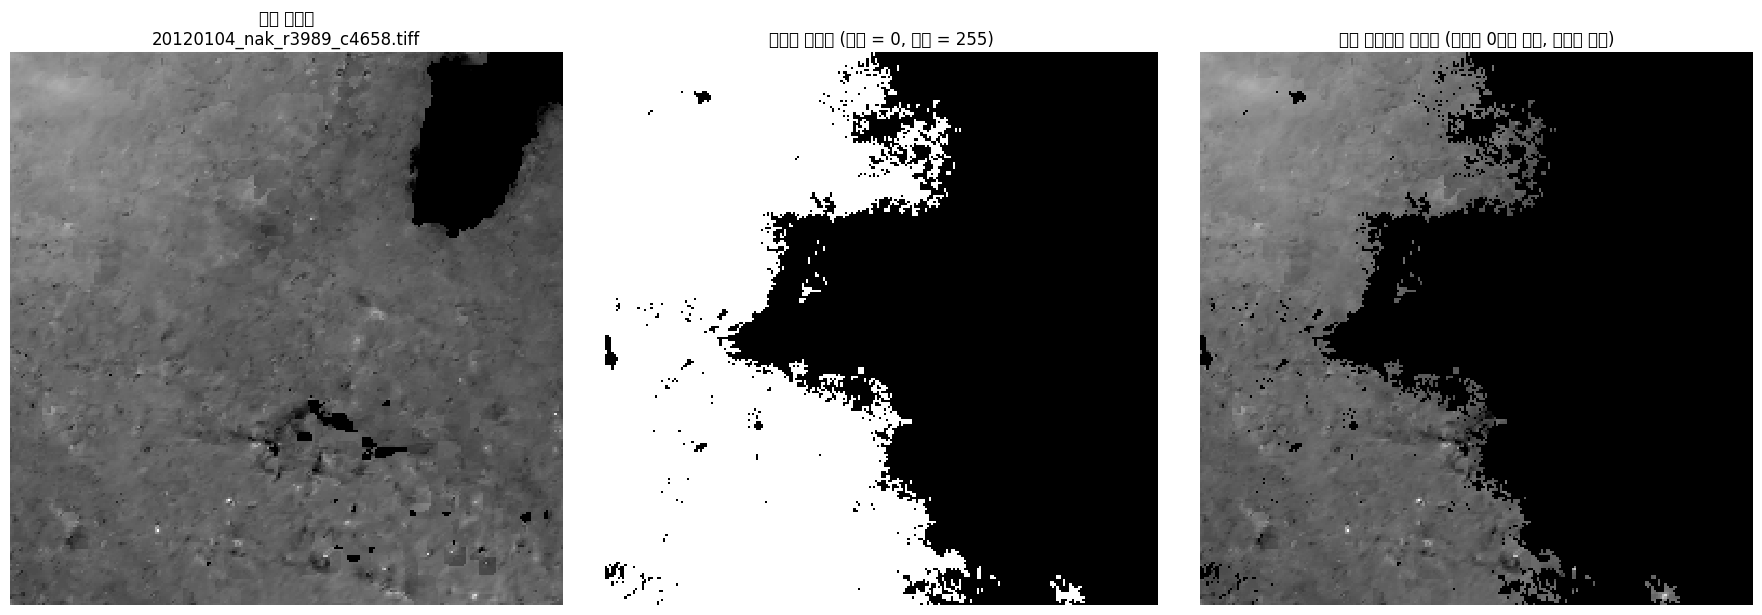

파일명: 20120105_nak_r3930_c4740.tiff
총 픽셀 수: 65536
TIFF 이미지에서 0 값 픽셀 수: 7400
0 값 픽셀 비율: 11.29%
최종 마스크된 이미지에서 NaN 비율: 1.02%


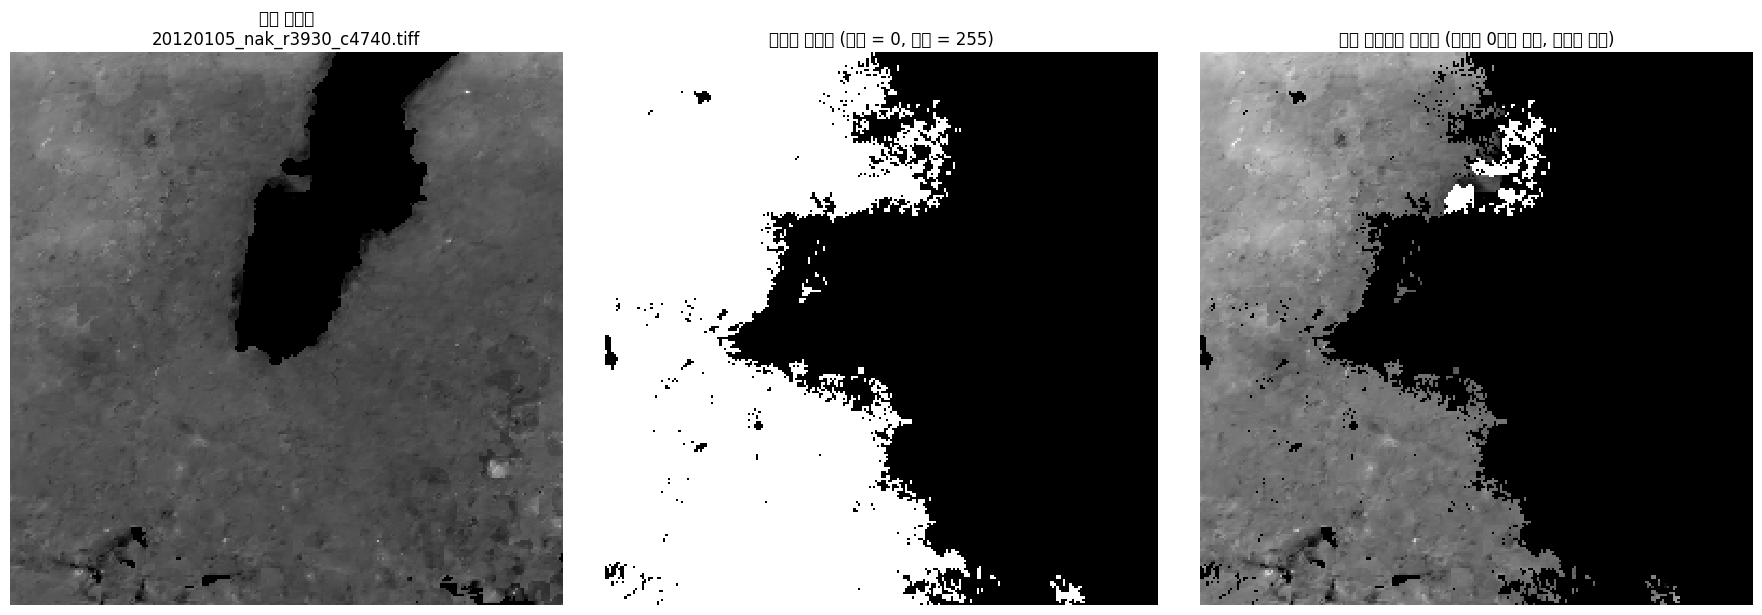

파일명: 20120105_nak_r3928_c4633.tiff
총 픽셀 수: 65536
TIFF 이미지에서 0 값 픽셀 수: 3656
0 값 픽셀 비율: 5.58%
최종 마스크된 이미지에서 NaN 비율: 0.00%


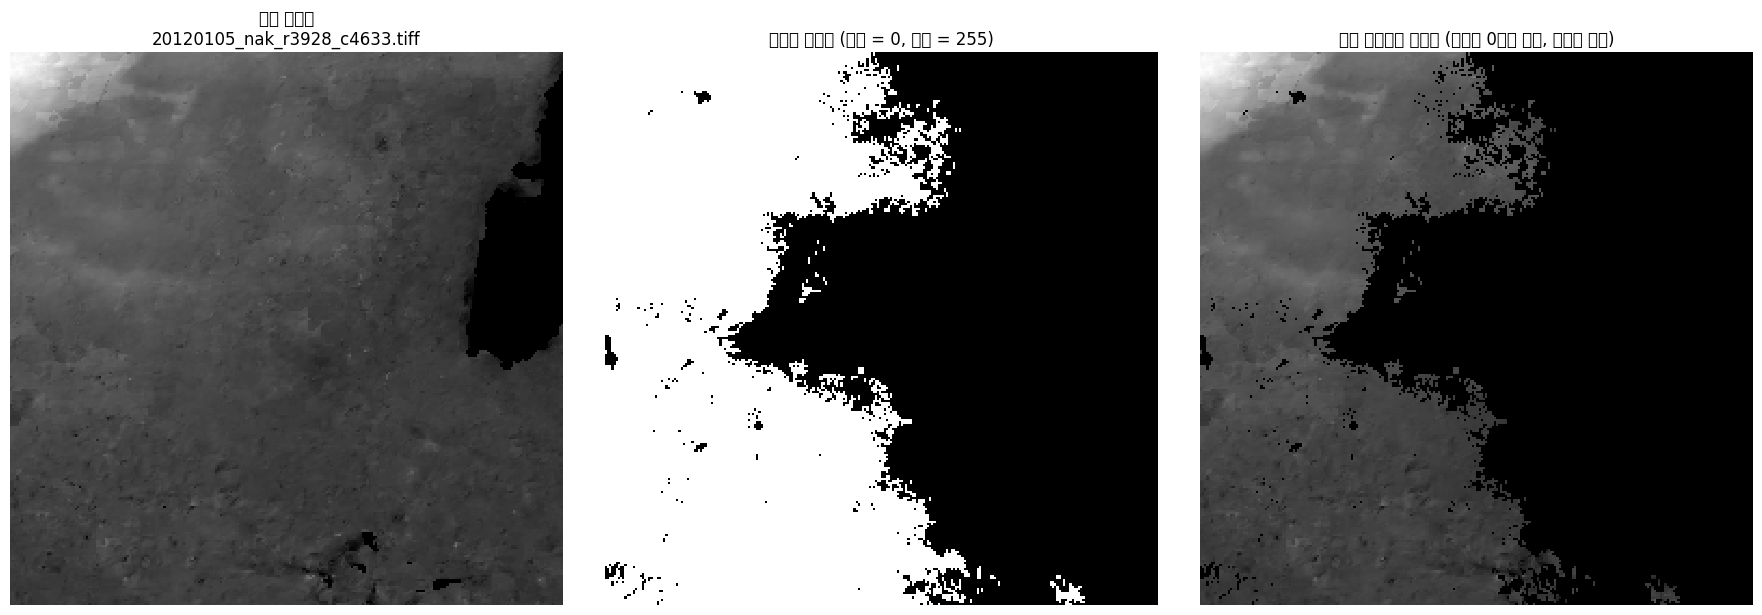

파일명: 20120104_nak_r4002_c4688.tiff
총 픽셀 수: 65536
TIFF 이미지에서 0 값 픽셀 수: 3835
0 값 픽셀 비율: 5.85%
최종 마스크된 이미지에서 NaN 비율: 0.03%


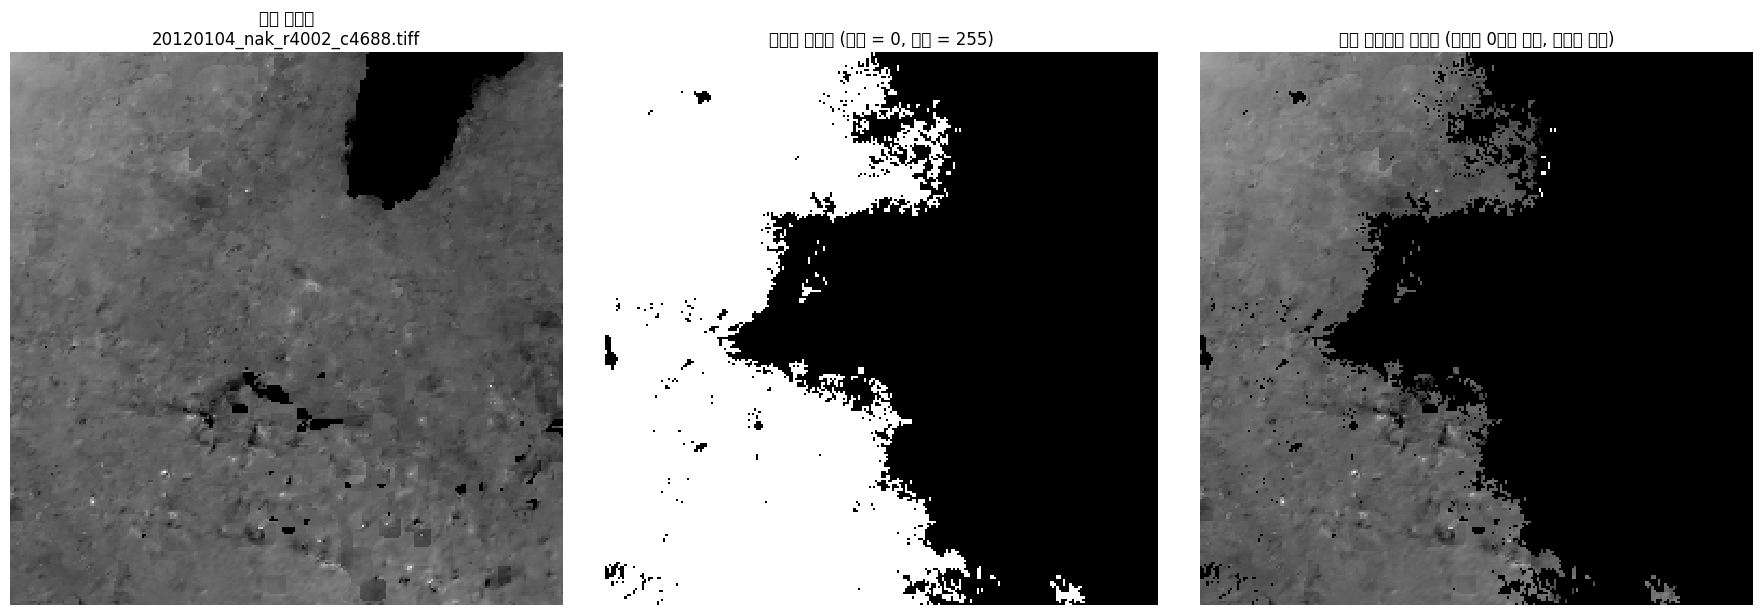

In [70]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import re  # 정규 표현식을 사용한 파일 이름 파싱
from scipy.io import loadmat

# 최상위 디렉토리 경로 설정
root_directory = "/home/juneyonglee/Documents"

# 마스크 파일 경로 설정 (올바른 경로로 업데이트 필요)
mask_file_path = "/home/juneyonglee/Documents/COMS_GOCI_L2A_GA_20200210061642._r3584_c1536.tiff.png"  

# 육지/해양 마스크 파일 경로 설정
land_mask_path = "/home/juneyonglee/Desktop/AY_ust/preprocessing/Land_mask/Land_mask.mat"

# 사용자 정의 컬러맵 생성 함수 (해양 데이터를 시각화하는 데 사용)
def create_custom_cmap():
    viridis = plt.cm.get_cmap('viridis', 256)  # viridis 컬러맵에서 256개의 색상 사용
    return ListedColormap(viridis(np.linspace(0, 1, 256)))

# 사용자 정의 컬러맵 설정
custom_cmap = create_custom_cmap()

# 정규 표현식을 사용하여 파일명에서 행(row)과 열(col) 값을 추출하는 함수
def extract_row_col(filename):
    match = re.search(r'r(\d+)_c(\d+)', filename)
    if match:
        row = int(match.group(1))
        col = int(match.group(2))
        return row, col
    return None, None

# 마스크 이미지 불러오기 함수
def load_mask(mask_file_path):
    mask = cv2.imread(mask_file_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise ValueError(f"마스크 파일 {mask_file_path}을(를) 불러올 수 없습니다.")
    
    # 마스크 변환: 255 (해양)을 1로 변환하고, 0 (육지)은 그대로 유지
    mask = np.where(mask == 255, 1, 0)
    
    print(f"마스크 로드 완료, 모양: {mask.shape}, 고유 값: {np.unique(mask)}")
    return mask

# .mat 파일에서 육지/해양 마스크를 불러오는 함수
def load_land_sea_mask(land_mask_path):
    # .mat 파일에서 육지/해양 마스크 불러오기 (육지 = 999, 해양 = 1)
    land_sea_mask = loadmat(land_mask_path)['Land']
    # 0을 999 (육지)로 변환하고, 1은 해양으로 유지
    land_sea_mask = np.where(land_sea_mask == 0, 999, 1)
    return land_sea_mask

# 마스크 로드 및 적용
mask = load_mask(mask_file_path)
land_sea_mask = load_land_sea_mask(land_mask_path)

# 최상위 디렉토리의 모든 하위 디렉토리와 파일을 처리
image_count = 0  # 출력된 이미지 수 카운터
max_images = 20  # 출력할 최대 이미지 수

for dirpath, dirnames, filenames in os.walk(root_directory):
    print(f"현재 폴더: {dirpath}")  # 현재 폴더 경로 출력
    
    # 해당 폴더 내의 모든 TIFF 파일을 처리
    for filename in filenames:
        if filename.endswith(".tiff"):  # TIFF 파일만 처리
            file_path = os.path.join(dirpath, filename)
            
            # 파일명에서 행(row)과 열(col) 값을 추출
            row, col = extract_row_col(filename)
            if row is None or col is None:
                continue  # 행과 열을 추출할 수 없으면 건너뜀
            
            # 이미지 불러오기
            img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"이미지를 불러올 수 없습니다: {file_path}")
                continue
            
            # 이미지 크기에 맞게 육지/해양 마스크의 해당 패치를 자르기
            land_mask_patch = land_sea_mask[row:row+img.shape[0], col:col+img.shape[1]]
            
            if land_mask_patch.shape != img.shape:
                print(f"경고: 육지/해양 마스크 패치의 크기 {land_mask_patch.shape}가 이미지 크기 {img.shape}와 맞지 않습니다")
                continue  # 마스크 패치 크기가 이미지와 맞지 않으면 건너뜀

            # 마스크 크기가 이미지 크기와 일치하지 않으면 마스크 크기 조정
            if mask.shape[:2] != img.shape[:2]:
                print(f"마스크 크기를 {mask.shape[:2]}에서 {img.shape[:2]}로 조정")
                mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            else:
                mask_resized = mask
            
            # 이미지에서 값이 0인 픽셀 비율 계산
            zero_pixel_count = np.count_nonzero(img == 0)
            total_pixels = img.size
            zero_pixel_percentage = (zero_pixel_count / total_pixels) * 100

            # 해양 부분은 마스킹하고 육지 부분은 유지한 이미지 생성
            masked_image = np.where((land_mask_patch == 1) & (mask_resized == 1), np.nan, img)

            # 해양 영역을 다시 마스킹 (해양을 0으로 설정)
            final_ocean_masked_image = np.where(mask_resized == 0, 1, masked_image)

            # 최종 마스크된 이미지에서 NaN 값 비율 계산
            nan_count = np.count_nonzero(np.isnan(final_ocean_masked_image))
            total_count = final_ocean_masked_image.size
            nan_ratio = (nan_count / total_count) * 100

            print(f"파일명: {filename}")
            print(f"총 픽셀 수: {total_pixels}")
            print(f"TIFF 이미지에서 0 값 픽셀 수: {zero_pixel_count}")
            print(f"0 값 픽셀 비율: {zero_pixel_percentage:.2f}%")
            print(f"최종 마스크된 이미지에서 NaN 비율: {nan_ratio:.2f}%")

            # 이미지를 3열로 나누어 시각화
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))
            
            # 첫 번째 열: 원본 이미지
            # axs[0].imshow(img, cmap=custom_cmap, interpolation='none')
            axs[0].imshow(img, cmap='grey', interpolation='none')
            axs[0].set_title(f"원본 이미지\n{filename}")
            axs[0].axis('off')  # 축 제거
            
            # 두 번째 열: 적용된 마스크 이미지 (육지 = 0, 해양 = 255)
            axs[1].imshow(mask_resized * 255, cmap=ListedColormap(['black', 'white']), interpolation='none')
            axs[1].set_title("적용된 마스크 (육지 = 0, 해양 = 255)")
            axs[1].axis('off')  # 축 제거
            
            # 세 번째 열: 최종 마스크된 이미지 (해양을 0으로 설정, 육지는 유지)
            # axs[2].imshow(final_ocean_masked_image, cmap=custom_cmap, interpolation='none')
            axs[2].imshow(final_ocean_masked_image, cmap='grey', interpolation='none')
            axs[2].set_title("최종 마스크된 이미지 (해양을 0으로 설정, 육지는 유지)")
            axs[2].axis('off')  # 축 제거
            
            # 플롯 출력
            plt.tight_layout()
            plt.show()

            image_count += 1  # 이미지 카운터 증가
            if image_count >= max_images:  # 최대 이미지 수에 도달하면 종료
                break
    if image_count >= max_images:  # 상위 루프에서 최대 이미지 수에 도달하면 종료
        break


Processing GT: 20120104_nak_r3990_c4732.tiff with Random Mask: COMS_GOCI_L2A_GA_20200210031642._r2560_c2560.tiff.png
Loaded land-sea mask with shape: (8000, 10500)
land_sea_mask[  1 999]
mask_image[  0 255]
land_sea_mask_patch[  1 999]


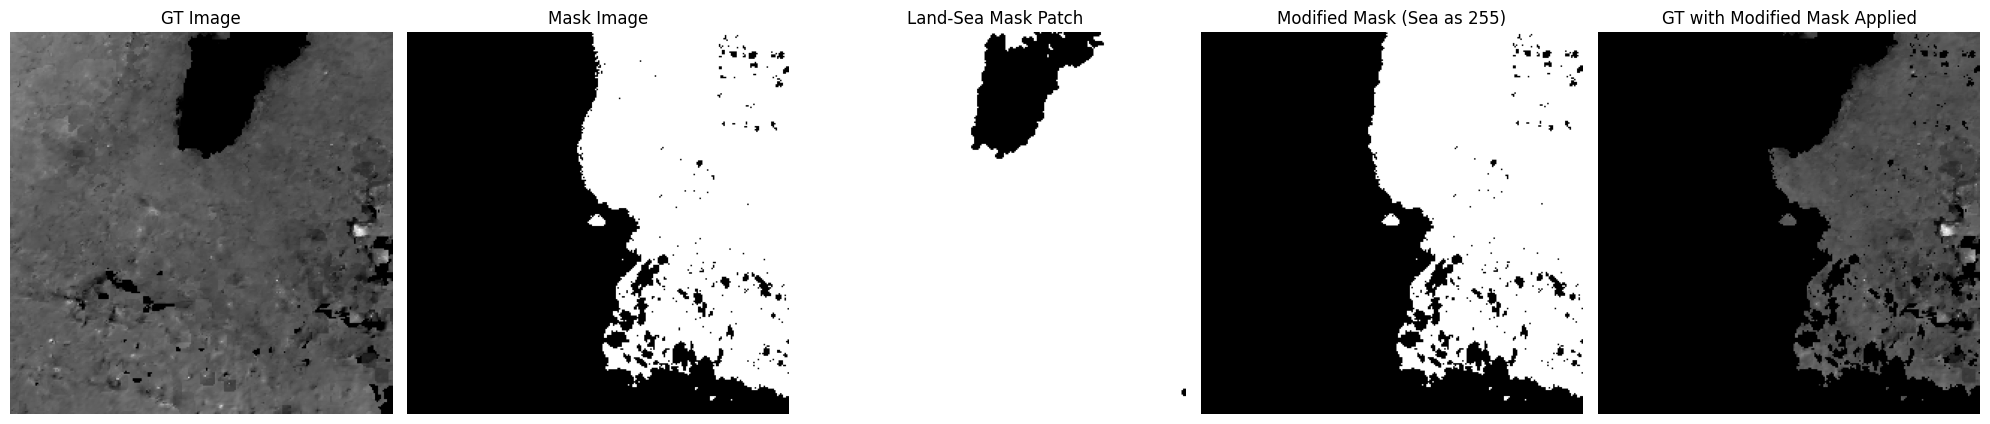

Processing GT: 20120104_nak_r4005_c4575.tiff with Random Mask: COMS_GOCI_L2A_GA_20200210061642._r3584_c1536.tiff.png
Loaded land-sea mask with shape: (8000, 10500)
land_sea_mask[  1 999]
mask_image[  0 255]
land_sea_mask_patch[999]


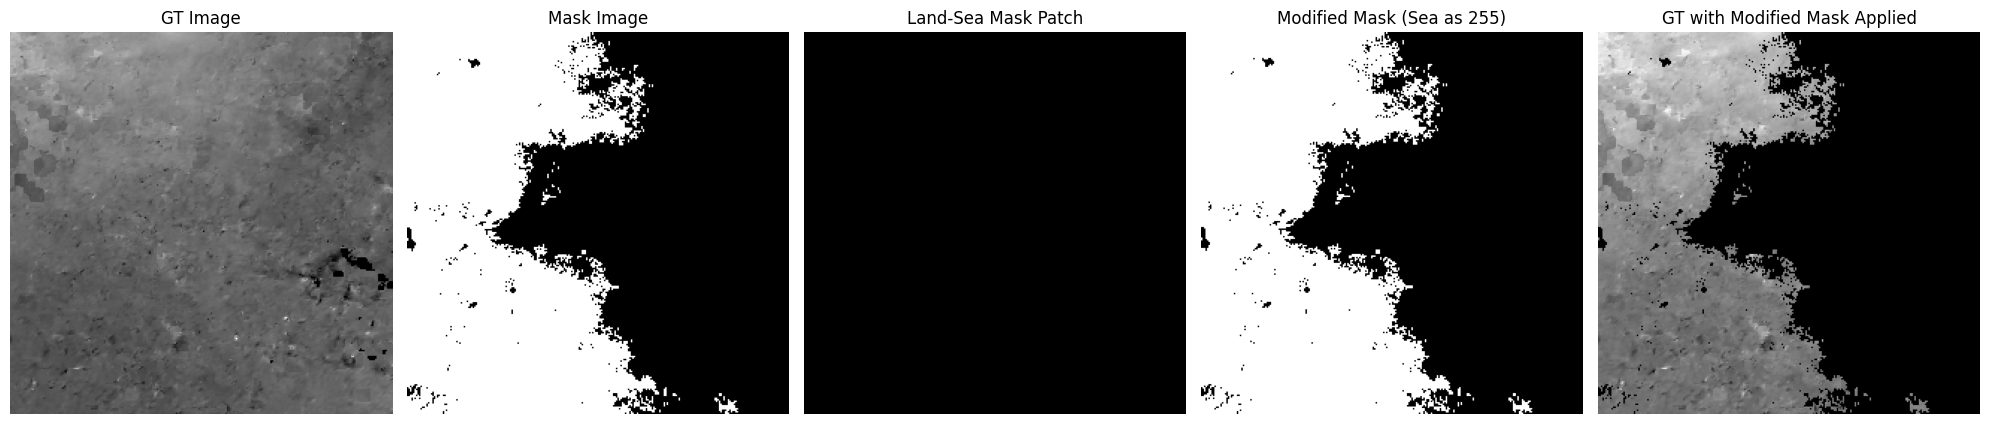

Processing GT: 20120104_nak_r3989_c4658.tiff with Random Mask: COMS_GOCI_L2A_GA_20200210021642._r4608_c2560.tiff.png
Loaded land-sea mask with shape: (8000, 10500)
land_sea_mask[  1 999]
mask_image[  0 255]
land_sea_mask_patch[  1 999]


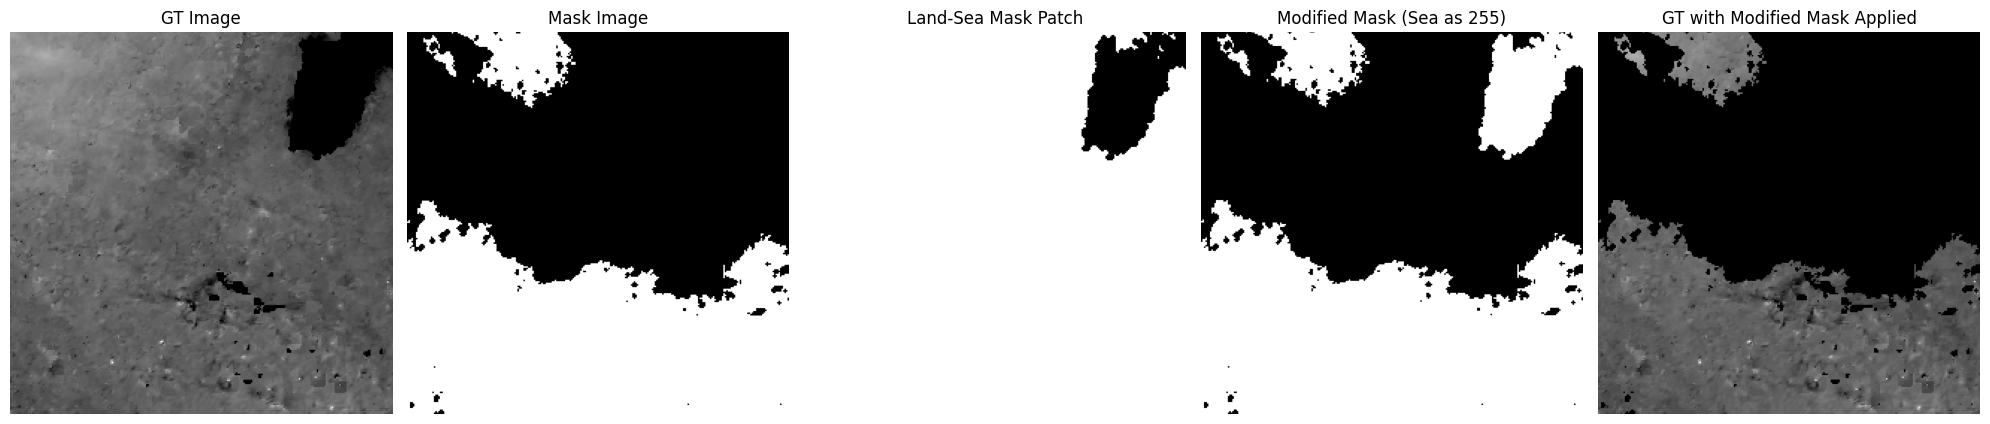

Processing GT: 20120105_nak_r3930_c4740.tiff with Random Mask: COMS_GOCI_L2A_GA_20200210021642._r4352_c1024.tiff.png
Loaded land-sea mask with shape: (8000, 10500)
land_sea_mask[  1 999]
mask_image[  0 255]
land_sea_mask_patch[  1 999]


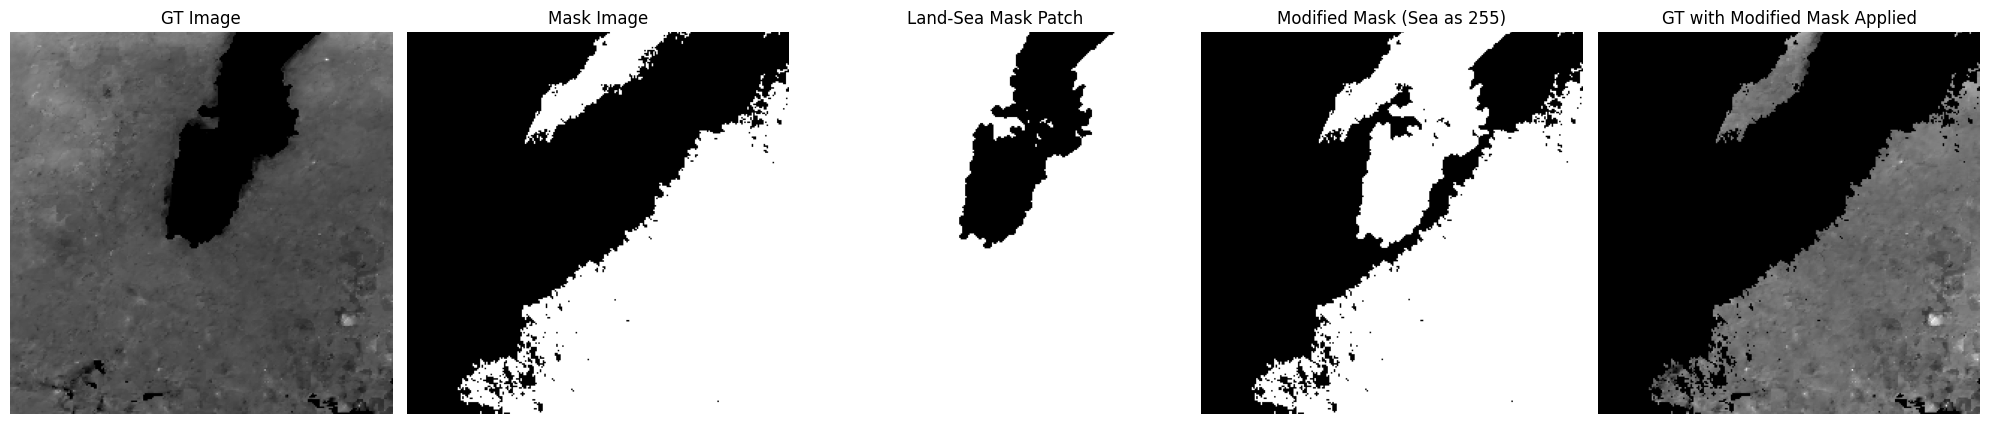

Processing GT: 20120105_nak_r3928_c4633.tiff with Random Mask: COMS_GOCI_L2A_GA_20200210021642._r4352_c1024.tiff.png
Loaded land-sea mask with shape: (8000, 10500)
land_sea_mask[  1 999]
mask_image[  0 255]
land_sea_mask_patch[  1 999]


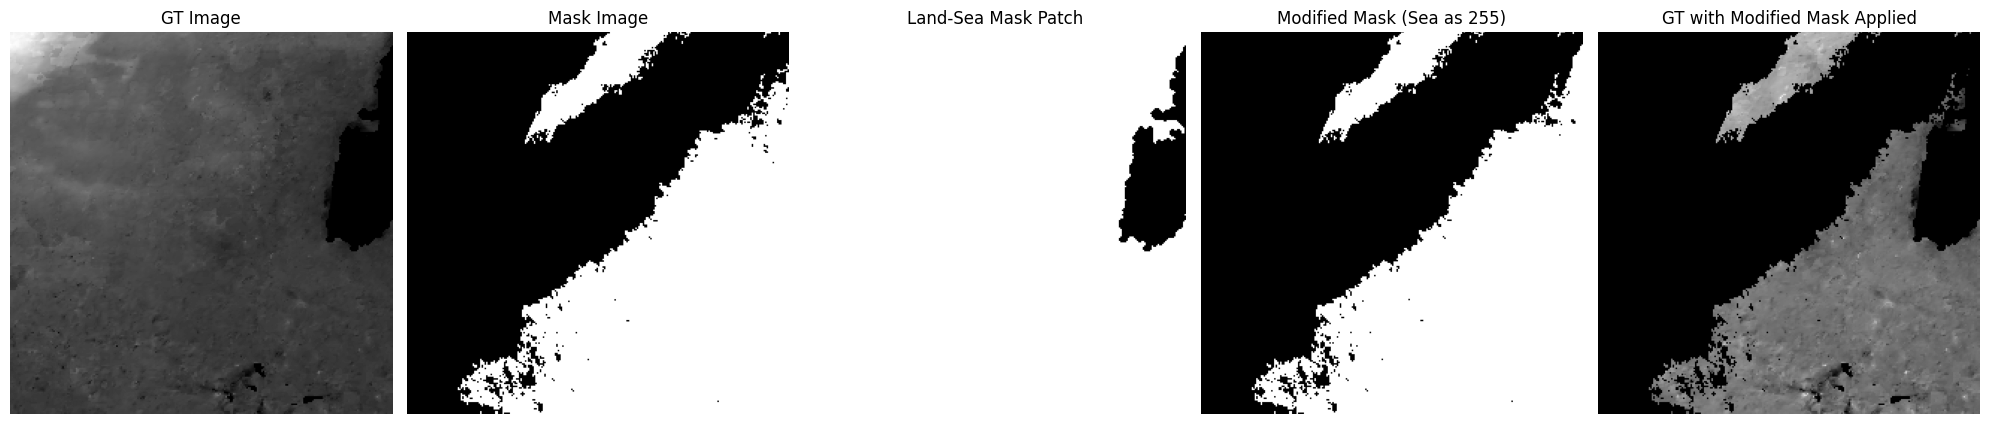

Processing GT: 20120104_nak_r4002_c4688.tiff with Random Mask: COMS_GOCI_L2A_GA_20200210021642._r4352_c1024.tiff.png
Loaded land-sea mask with shape: (8000, 10500)
land_sea_mask[  1 999]
mask_image[  0 255]
land_sea_mask_patch[  1 999]


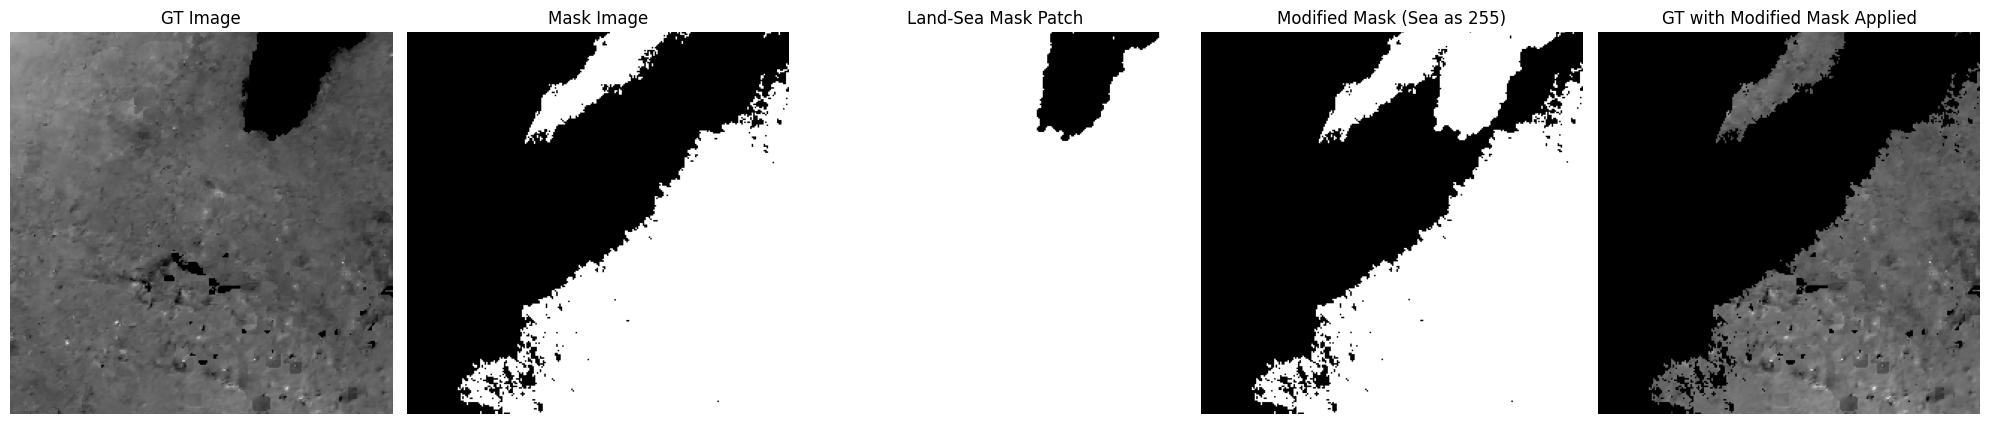

In [117]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import random

# Function to extract row and column from filename using regex
def extract_row_col(filename):
    match = re.search(r'r(\d+)_c(\d+)', filename)
    if match:
        row = int(match.group(1))
        col = int(match.group(2))
        return row, col
    return None, None

# Load the land-sea mask from a .npy file
def load_land_sea_mask(land_mask_path):
    land_sea_mask = np.load(land_mask_path)
    print(f"Loaded land-sea mask with shape: {land_sea_mask.shape}")
    return land_sea_mask

# Function to get the land-sea mask patch (before conversion)
def get_land_sea_mask_patch(img, filename, land_sea_mask):
    imgh, imgw = img.shape[:2]
    row, col = extract_row_col(filename)
    
    if row is None or col is None:
        raise ValueError(f"Row or column could not be extracted from filename: {filename}")
    
    # Extract the corresponding patch from the land-sea mask
    land_sea_mask_patch = land_sea_mask[row:row + imgh, col:col + imgw]
    
    if land_sea_mask_patch.shape != (imgh, imgw):
        raise ValueError(f"Shape mismatch: land-sea mask patch {land_sea_mask_patch.shape} does not match image shape {img.shape}")
    
    return land_sea_mask_patch

# Function to create a new mask by removing land areas from mask_image and setting sea areas to 255
def remove_land_from_mask(mask_image, land_sea_mask_patch):
    """
    Given a mask image and a land-sea mask patch, modify the mask:
    - Remove land areas (999) from the mask (set to 0)
    - Set the sea areas (where land_sea_mask_patch == 1 and mask_image == 0) to 255
    """
    # Set ocean (1) pixels where the mask is 0 to 255, leave land (999) as 0
    mask_modified = np.where((land_sea_mask_patch == 1) & (mask_image == 0), 255, mask_image)
    return mask_modified

# Function to visualize the step-by-step process for each image
def visualize_masking_process(gt_image_path, mask_image_path, land_mask_path):
    # Step 1: Load GT image
    gt_image = cv2.imread(gt_image_path, cv2.IMREAD_UNCHANGED)
    
    if gt_image is None:
        raise ValueError(f"GT image not found: {gt_image_path}")
    
    # Step 2: Load mask image
    mask_image = cv2.imread(mask_image_path, cv2.IMREAD_UNCHANGED)
    
    if mask_image is None:
        raise ValueError(f"Mask image not found: {mask_image_path}")
    
    # Ensure mask is binary (0 or 255)
    mask_image = (mask_image > 0).astype(np.uint8) * 255
    
    # Step 3: Load the land-sea mask
    land_sea_mask = load_land_sea_mask(land_mask_path)
    print(f'land_sea_mask{np.unique(land_sea_mask)}')  # 육지(999), 해양(1) 확인
    
    # Get the land-sea mask patch corresponding to the GT image
    land_sea_mask_patch = get_land_sea_mask_patch(gt_image, gt_image_path, land_sea_mask)
    
    # Step 4: Modify the mask (set sea areas where mask is 0 to 255)
    mask_modified = remove_land_from_mask(mask_image, land_sea_mask_patch)
    
    # Step 5: Apply the modified mask to the GT image
    ocean_restoration_mask = gt_image * (mask_modified > 0)  # Apply mask to GT image
    print(f'mask_image{np.unique(mask_image)}')  # 원래 마스크 값 (0, 255)
    print(f'land_sea_mask_patch{np.unique(land_sea_mask_patch)}')  # 육지, 해양 마스크 값 (999, 1)
    
    # Visualize each step
    fig, axes = plt.subplots(1, 5, figsize=(20, 8))
    
    # Step 1: GT Image
    axes[0].imshow(gt_image, cmap='gray')
    axes[0].set_title(f'GT Image')
    axes[0].axis('off')
    
    # Step 2: Mask Image
    axes[1].imshow(mask_image, cmap='gray')
    axes[1].set_title(f'Mask Image')
    axes[1].axis('off')
    
    # Step 3: Land-Sea Mask Patch (Original)
    axes[2].imshow(land_sea_mask_patch, cmap='gray')  # Original land-sea mask patch before modification
    axes[2].set_title('Land-Sea Mask Patch')
    axes[2].axis('off')
    
    # Step 4: Modified Mask (Without Land, Sea Set to 255)
    axes[3].imshow(mask_modified, cmap='gray')  # Mask with land areas removed and sea areas set to 255
    axes[3].set_title('Modified Mask (Sea as 255)')
    axes[3].axis('off')
    
    # Step 5: Ocean Restoration Mask (GT * Modified Mask)
    axes[4].imshow(ocean_restoration_mask, cmap='gray')  # Restored image with only ocean areas
    axes[4].set_title('GT with Modified Mask Applied')
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to process all images in the directory
def process_all_images_in_directory(gt_image_dir, mask_image_dir, land_mask_path):
    gt_images = glob.glob(os.path.join(gt_image_dir, "*.tiff"))
    mask_images = glob.glob(os.path.join(mask_image_dir, "*.png"))
    
    for gt_image_path in gt_images:
        gt_filename = os.path.basename(gt_image_path)
        
        # Randomly select a mask from the available mask images
        mask_image_path = random.choice(mask_images)
        
        print(f"Processing GT: {gt_filename} with Random Mask: {os.path.basename(mask_image_path)}")
        visualize_masking_process(gt_image_path, mask_image_path, land_mask_path)

# Example usage with provided directory paths
gt_image_dir = "/home/juneyonglee/Documents"  # Directory containing GT images
mask_image_dir = "/home/juneyonglee/Documents"  # Directory containing mask images
land_mask_path = "/home/juneyonglee/Desktop/AY_ust/preprocessing/Land_mask/Land_mask.npy"

process_all_images_in_directory(gt_image_dir, mask_image_dir, land_mask_path)
